In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import sounddevice as sd
import math
import time
import cmath
import sys
import os
import random
import tabletext

# Что происходит в этом файле

Голосовая идентификация.

А именно, к концу этого файла создается функция, которая выдает "похожесть" двух записей друг на друга относительно источника.
Чтобы записи были хорошо похожи друг на друга, лучше произносить одну и ту же фразу.

Процесс:

1. Запись голоса (чтение готового файла)
2. Выделяем несколько фрагментов, которые будем анализировать (такие, на которых заметны колебания, то есть что-то говорят
3. Выполняем спектральный анализ с помощью быстрого преобразования Фурье для выделения амплитуд в голосе (иначе говоря, раскладываем на частоты)
4. Выделяем топ пиков (самые высокие локальные максимумы, а для каждой частоты пика запоминаем амплитуду.
5. Склеиваем этот топ пиков по всем фрагментам (считаем динамическое программирование с разбиением точек на K групп, где группой считается блок из точек с разницей не более 50 герц друг от друга), оптимизируется функция $$\displaystyle \sum_{i=1}^n \frac{amp_i}{1.05^{|x_i - center(x_i)|}}$$
6. Получаем вектор, который отвечает за то, какими частотами (усредненными) характеризуется голос
7. Чтобы сравнить два метода, используем расстояние Левенштейна, адаптированное под вещественные последовательности

In [2]:
fs = 44100
PARAMETERS = {
    "sample_length": 0.10,
    "record_length": 2,
    "peaks": 25,
    "output_dim": 20,
    "exp": 1.05,
    "peak_criterion": 3,
    "delta": 0.1,
    "penalty": 100,
    'iterations': 15,
    'pts_diff': 5,
    'group': 50
}

In [3]:
def read(name):
    n_data = sf.read('auth/' + name + '_voice.wav')[0] # if use this, use n_data[0]
    sd.play(n_data, fs)
    sd.wait()
    return list(n_data)

def record(name):
    global PARAMETERS
    time.sleep(0.5)
    print('record')
    n_data = sd.rec(PARAMETERS["record_length"] * fs, samplerate=fs, channels=1)
    sd.wait()
    print('play')
    sd.play(n_data, fs)
    sd.wait()
    sf.write('auth/' + name + '_voice.wav', n_data, samplerate=fs);
    return list(n_data)

In [4]:
def normalize_result(val):
    ln = len(val)
    ampl = [0] * ln
    arg = [0] * ln
    for i in range(0, len(val)):
        ampl[i] = abs(val[i]) / ln
        arg[i] = val[i].imag
    return ampl, arg

In [5]:
'''
slow version
 result = []
 for i in range(len(A)):
     result.append(complex(0))
     for j in range(len(A)):
         result[i] += A[j] * complex(math.cos(2 * math.pi * i * j / len(A)), -math.sin(2 * math.pi * i * j / len(A)))
 return result
'''
def fft(A):
    if len(A) == 1:
        return A
    assert len(A) % 2 == 0
    n =	len(A)
    a, b = [], []
    for i in range(0, n):
        if (i % 2 == 0):
            a.append(A[i].copy())
        else:
            b.append(A[i].copy())
    a = fft(a)
    b = fft(b)
    result = [complex(1) for _ in range(n)]
    pw = complex(1)
    w = complex(math.cos(2 * math.pi / n), math.sin(2 * math.pi / n))	
    for i in range(0, n // 2):
        tmp = pw * b[i]
        result[i] = a[i] + pw * b[i]
        result[i + n // 2] = a[i] - pw * b[i]
        pw *= w
    return result

In [6]:
def hamming(index, n):
    return 0.54 - 0.46 * math.cos((2 * math.pi * index) / (n - 1))

In [7]:
def find_peaks(arr, n, top_k=PARAMETERS["peaks"]):
    global PARAMETERS
    assert n > 200
    assert top_k <= n * 0.90
    result = []
    for i in range(int(n * 0.01), int(n * 0.99)):
        ok = True
        mn = arr[i]
        for j in range(int(-n * 0.01), int(n * 0.01)):
            idx = int(i + j)
            mn = min(arr[i + j], mn)
            if arr[idx] > arr[i]:
                ok = False
                break
        if ok and mn * PARAMETERS["peak_criterion"] < arr[i]:
            result.append((arr[i] - mn * PARAMETERS["peak_criterion"], i))
    return sorted(result)[::-1][:top_k]

In [8]:
def merge_similarities(arr, k = PARAMETERS["output_dim"]):
    n = len(arr)
    result = []
    arr.sort(key=lambda x: x[1])
    dp = [[-10**10 for j in range(k + 1)] for i in range(n + 1)]
    pre = [[(i - 1, i - 1, 0) for j in range(k + 1)] for i in range(n + 1)]
    dp[0][0] = 0
    for i in range(1, n + 1):
        for j in range(k, 0, -1):
            dp[i][j] = dp[i - 1][j]
            pre[i][j] = pre[i - 1][j]
            if dp[i][j - 1] > dp[i][j]:
                dp[i][j] = dp[i][j - 1]
                pre[i][j] = pre[i][j - 1]
            l = i - 1
            while l >= 0 and arr[i - 1][1] - arr[l][1] <= PARAMETERS['group']:
                l -= 1
                assert i >= 1
            calc = 0
            x_mean = 0
            sm = 0
            for f in range(l + 1, i):
                x_mean += arr[f][0] * arr[f][1]
                sm += arr[f][0]
            x_mean /= sm
            for f in range(l + 1, i):
                calc += arr[f][0] / PARAMETERS["exp"] ** (abs(arr[f][1] - x_mean))
            if calc + dp[l][j - 1] > dp[i][j]:
                dp[i][j] = calc + dp[l][j - 1]
                pre[i][j] = (l, x_mean, -1)
    fin = [n, k]
    res = []
    while fin[1] >= 0 and fin[0] >= 0:
        pr = pre[fin[0]][fin[1]]
        if pr[2] != 0:
            res.append(pr[1])
        fin[0] = pr[0]
        fin[1] += pr[2]
    return res

In [9]:
def get_vector(name, iterations=PARAMETERS['iterations'], visualize=False):
    data = np.array(read(name))
    if visualize:
        plt.plot(data)
        plt.show()
    ln = len(data)
    new_ln = 1
    while new_ln < fs * PARAMETERS["sample_length"]:
        new_ln *= 2
    peaks = []
    for start_idx in range(iterations):
        start = random.randint(0, len(data) - new_ln)
        np_data = np.array(data)[start:start + new_ln]
        while True:
            if np_data.max() - np_data.min() > PARAMETERS["delta"]:
                break
            start = random.randint(0, len(data) - new_ln)
            np_data = np.array(data)[start:start + new_ln]
           
        np_data = fft(np_data)
        for i in range(len(np_data)):
            np_data[i] *= hamming(i, len(np_data))
        ampl, arg = normalize_result(np_data)
        
        '''
        to scale array
        '''
        def get(arr, idx):
            k = PARAMETERS["sample_length"] * 2
            if int(idx * k) == idx * k:
                return arr[int(idx * k)]
            diff = idx * k - int(idx * k)
            return arr[int(idx * k)] * diff + arr[int(idx * k) + 1] * (1 - diff)
        
        res = [get(ampl, i) for i in range(5000)]
        if visualize:
            plt.plot(res, alpha=0.5)
        peaks.extend(find_peaks(res, len(res)))
    if visualize:
        plt.show()
    return merge_similarities(peaks)

In [10]:
get_vector('misha', 10)

[4798.742888695172,
 4519.096785185787,
 4102.7157537441235,
 3923.9557924147252,
 3779.787257758688,
 3694.585345336107,
 3622.6009345929187,
 3518.544394242849,
 3413.4184617766823,
 3288.7778718992695,
 3163.3713054235723,
 1908.6404184073297,
 1750.0,
 778.766861211048,
 676.7077930788162,
 516.0700118436692,
 456.70368452678156,
 332.5590015875861,
 264.92161159987427,
 141.17510773979706]

In [11]:
get_vector('misha2', 10)

[3401.778794808739,
 3257.829460700153,
 3150.39442952289,
 3022.402203775611,
 2373.025790985029,
 2311.00258952605,
 1438.304555798758,
 1227.9972883646012,
 1073.2966355671786,
 926.2351888566391,
 837.6799996346709,
 762.9718505370835,
 698.2150283079429,
 609.5932933696884,
 433.17752818268764,
 345.41297805482606,
 236.1959278488763,
 147.91895418182244,
 102.1420010548066,
 50.0]

In [12]:
def score(a, b):
    assert(len(a) == len(b))
    n = len(a)
    dp = [[10 ** 10 for i in range(n + 1)] for j in range(n + 1)]
    dp[0][0] = 0
    penalty = PARAMETERS['penalty']
    for i in range(n + 1):
        for j in range(n + 1):
            if i == 0 and j == 0:
                continue
            if i == 0:
                dp[i][j] = dp[i][j - 1] + penalty
            elif j == 0:
                dp[i][j] = dp[i - 1][j] + penalty
            else:
                dp[i][j]= min(min(dp[i - 1][j], dp[i][j - 1]) + penalty, dp[i - 1][j - 1] + abs(a[i - 1] - b[j - 1]) * PARAMETERS['pts_diff'])
    return dp[n][n]

In [13]:
score(get_vector('misha'), get_vector('misha2'))

2987.0594331944244

In [14]:
score(get_vector('misha'), get_vector('misha'))

1482.8433617752564

In [15]:
score(get_vector('misha', 10), get_vector('misha', 10))

1918.6178217363633

In [16]:
score(get_vector('misha'), get_vector('kirill2'))

3079.194275300872

In [17]:
score(get_vector('misha2'), get_vector('kirill2'))

3446.9319374196416

In [18]:
score(get_vector('misha'), get_vector('misha_2024'))

3479.547418773813

In [19]:
# record('kirill_bob')

In [20]:
# record('kirill_pop')

In [21]:
# record('kirill_privat')

In [22]:
# record('kirill_sobaka')

In [23]:
# record('misha_bob')

In [24]:
# record('misha_pop')

In [25]:
# record('misha_load')

In [26]:
# record('misha_sobaka')

In [27]:
names = ['kirill_pop', 'kirill_bob', 'kirill_privat', 'kirill_sobaka', 'misha_pop', 'misha_bob',  'misha_privat', 'misha_sobaka']
result = []
for a in names:
    result.append([])
    for b in names:
        result[-1].append(score(get_vector(a), get_vector(b)))

In [28]:
print(tabletext.to_text(result))

┌────────────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│  452.8112509059199 │ 2451.3760327990335 │ 3287.2931587142684 │ 3175.3718521835917 │ 3260.9679336616423 │  3317.098076384909 │ 3715.3941338552277 │ 3420.3332630312143 │
├────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│  2687.572614956133 │  677.7601662021655 │ 2979.1495478360807 │ 2816.8886196991302 │  3101.147177436781 │   3351.34182059114 │ 3259.6565768226505 │ 2750.8122501742077 │
├────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ 3295.7310888363427 │  3298.503482775076 │ 1844.0760948166148 │  2895.736258327581 │ 3040.8584386662505 │ 3283.4618166684595 │  2807.699282494625 │  

In [31]:
result = np.array(result)

In [32]:
result.min()

452.8112509059199

In [34]:
result.max()

3715.3941338552277

In [35]:
result = (result - result.min()) / (result.max() - result.min())

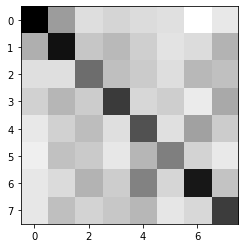

In [37]:
plt.imshow(result, cmap='gray')

┌────────────────────┬────────────────────┐
│ 0.6277872702559021 │ 0.8300107335529536 │
├────────────────────┼────────────────────┤
│ 0.8280246717273839 │ 0.6550791783282709 │
└────────────────────┴────────────────────┘


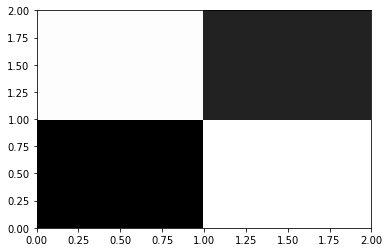

In [42]:
res_avg = [[0, 0], [0, 0]]
cnt = 0
for i in range(len(names) // 2):
    for j in range(len(names) // 2):
        add = len(names) // 2
        cnt += 1
        res_avg[0][0] += result[i][j]
        res_avg[0][1] += result[i][j + add]
        res_avg[1][0] += result[i + add][j]
        res_avg[1][1] += result[i + add][j + add]
res_avg = np.array(res_avg)
res_avg /= cnt
print(tabletext.to_text(res_avg))
plt.pcolormesh(res_avg, cmap='gray')

# Итог

Я не сильно подкручивал параметры, но разница все-таки есть, непохожие друг на друга голоса имеют больший score при сравнении. Актуальны только записи `'kirill_pop', 'kirill_bob', 'kirill_privat', 'kirill_sobaka', 'misha_pop', 'misha_bob',  'misha_privat', 'misha_sobaka'`. Предыдущие были сделаны на другой микрофон (и качеством они хуже) и теперь непонятно, как их сравнивать